## ConvLSTM Encoder-Decoder Model With Univariate Input
A further extension of the CNN-LSTM approach is to perform the convolutions of the CNN (e.g. how the CNN reads the input sequence data) as part of the LSTM for each time step.

This combination is called a Convolutional LSTM, or ConvLSTM for short, and like the CNN-LSTM is also used for spatio-temporal data.

Unlike an LSTM that reads the data in directly in order to calculate internal state and state transitions, and unlike the CNN-LSTM that is interpreting the output from CNN models, the ConvLSTM is using convolutions directly as part of reading input into the LSTM units themselves.

For more information for how the equations for the ConvLSTM are calculated within the LSTM unit, see the paper:

Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting, 2015.


We are working with a one-dimensional sequence of total power consumption, which we can interpret as one row with 14 columns, if we assume that we are using two weeks of data as input.
For the ConvLSTM, this would be a single read: that is, the LSTM would read one time step of 14 days and perform a convolution across those time steps. This is not ideal.
Instead, we can split the 14 days into two subsequences with a length of seven days. The ConvLSTM can then read across the two time steps and perform the CNN process on the seven days of data within each.

In [2]:
# univariate multi-step encoder-decoder convlstm
import numpy as np
from math import sqrt
from numpy import split
from numpy import array
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Flatten
from keras.layers import LSTM, Bidirectional, Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSProp

ImportError: cannot import name 'get_config' from 'tensorflow.python.eager.context' (C:\Users\korea\anaconda3\lib\site-packages\tensorflow\python\eager\context.py)

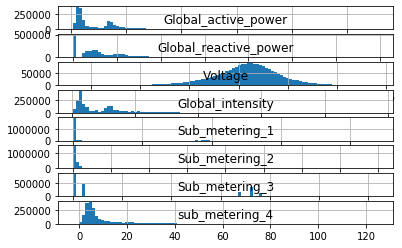

In [2]:
# histogram plots
from pandas import read_csv
from matplotlib import pyplot
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# histogram plot for each variable
pyplot.figure()
for i in range(len(dataset.columns)):
	pyplot.subplot(len(dataset.columns), 1, i+1)
	name = dataset.columns[i]
	dataset[name].hist(bins=100)
	pyplot.title(name, y=0)
pyplot.show()

In [3]:
print(dataset)

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

In [2]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# calculate mape
		mape = np.mean(np.abs((actual[:,i] - predicted[:,i]) / actual[:,i]))*100 
		# store
		scores.append(rmse)#mape, mse, rmse
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1])) # #sqrt
	# plot the results
#	print(predicted)
#	print(actual)
	fig = plt.figure()
	pyplot.plot(actual[:,3], label = 'actual')
	pyplot.plot(predicted[:,3], label = 'predicted')
	pyplot.legend()    
	plt.xlabel('Time')
	plt.ylabel('Normalized Electricity load')
	pyplot.show()
	fig.savefig('output_load_forecasting.jpg', bbox_inches='tight')    
	return score, scores

In [3]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
#			X.append(data[in_start:in_end, :])   #multivariate change         
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [7]:
# train the model CONVLSTM-LSTM
def build_model(train, n_steps, n_length, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 1000, 256
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, time steps, rows, cols, channels]
	train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model with 4 convlstm and 2 LSTM layers
	model = Sequential()
	model.add(ConvLSTM2D(filters=128, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features), return_sequences = True)) 
#	model.add(BatchNormalization())
	model.add((ConvLSTM2D(64, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))
	model.add((ConvLSTM2D(32, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))
	model.add((ConvLSTM2D(16, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))    
#	model.add(BatchNormalization())    
#	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features))))
#	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='elu', return_sequences = False))
#	model.add(BatchNormalization())    
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
#	model.add(Bidirectional(LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.001), return_sequences=True)))#     
	model.add((LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.001), return_sequences=True)))# 
#	model.add(Dropout(0.5))      
	model.add((LSTM(200, activation='relu', kernel_regularizer=regularizers.l2(0.001),return_sequences=True))) # kernel_regularizer=regularizers.l2(0.001),   
#	model.add(Dropout(0.5))  
#	model.add((LSTM(200, activation='relu', return_sequences=True)))    
#	model.add((LSTM(200, activation='relu', return_sequences=True)))    
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	opt = Adam(learning_rate = 0.001)
	model.compile(loss='mse', optimizer=opt)
	# fit network
	# fit network
	history = model.fit(train_x, train_y, epochs=epochs, validation_split=0.3,batch_size=batch_size, verbose=verbose)
	model.summary()
	pyplot.plot(history.history['loss'], label='train')
	pyplot.plot(history.history['val_loss'], label='val')
	pyplot.legend()
	plt.xlabel('Epochs')
	plt.ylabel('MSE')
	pyplot.show()      

	return model

In [194]:
# train the model CONVLSTM-BiLSTM
def build_model(train, n_steps, n_length, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 100, 64
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, time steps, rows, cols, channels]
	train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model with 4 convlstm and 2 LSTM layers
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features), return_sequences = True)) 
#	model.add(BatchNormalization())
##	model.add((ConvLSTM2D(64, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))
##	model.add((ConvLSTM2D(32, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))
##	model.add((ConvLSTM2D(16, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))    
#	model.add(BatchNormalization())    
#	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features))))
#	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='elu', return_sequences = False))
#	model.add(BatchNormalization())    
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))##
	model.add(Bidirectional(LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.001), return_sequences=True)))#     
##	model.add((LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.001), return_sequences=True)))# 
#	model.add(Dropout(0.5))      
##	model.add((LSTM(200, activation='relu', kernel_regularizer=regularizers.l2(0.001),return_sequences=True))) # kernel_regularizer=regularizers.l2(0.001),   
##	model.add(Dropout(0.5))  
#	model.add((LSTM(200, activation='relu', return_sequences=True)))    
#	model.add((LSTM(200, activation='relu', return_sequences=True)))    
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	# fit network
	history = model.fit(train_x, train_y, epochs=epochs, validation_split=0.3,batch_size=batch_size, verbose=verbose)
	model.summary()
	pyplot.plot(history.history['loss'], label='train')
	pyplot.plot(history.history['val_loss'], label='val')
	pyplot.legend()
	plt.xlabel('Epochs')
	plt.ylabel('MSE')
	pyplot.show()      

	return model

In [5]:
# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:,0]     # 0 for univariate and : fro mutivariate
	# reshape into [samples, time steps, rows, cols, channels]
	input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    
	# retrieve last observations for input data
#	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
#	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))    
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [6]:
# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
	# fit model
	model = build_model(train, n_steps, n_length, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 2, 1, 5, 128)      198656    
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 2, 1, 5, 64)       147712    
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 2, 1, 5, 32)       36992     
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 2, 1, 5, 16)       9280      
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 160)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 7, 200)            2

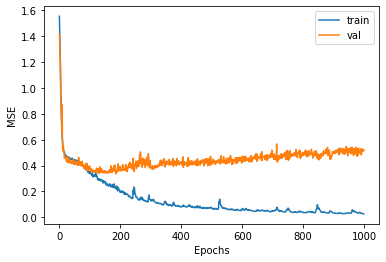

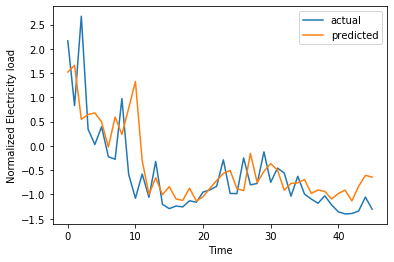

Convlstm: [0.683] 0.4, 0.6, 0.7, 0.6, 0.7, 0.9, 0.8


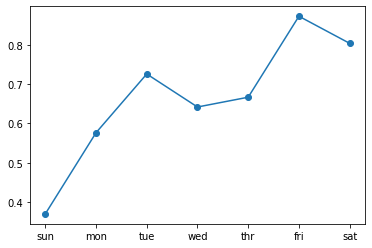

In [8]:
# load the new file
#dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
dataset = read_csv('modelData_season_daily.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
#dataset = read_csv('ISONE_daily.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])


#Standardize the dataset
data_mean = dataset[:].mean(axis=0)
data_std = dataset[:].std(axis=0)
dataset = (dataset-data_mean)/data_std

# split into train and test
train, test = split_dataset(dataset.values)
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2,7
# define the total days to use as input
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)


# summarize scores
summarize_scores('Convlstm', score, scores)

# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [ ]:
# Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv_lst_m2d_50 (ConvLSTM2D) (None, 2, 1, 5, 128)      198656    
_________________________________________________________________
conv_lst_m2d_51 (ConvLSTM2D) (None, 2, 1, 5, 64)       147712    
_________________________________________________________________
conv_lst_m2d_52 (ConvLSTM2D) (None, 2, 1, 5, 32)       36992     
_________________________________________________________________
conv_lst_m2d_53 (ConvLSTM2D) (None, 2, 1, 5, 16)       9280      
_________________________________________________________________
flatten_16 (Flatten)         (None, 160)               0         
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 7, 160)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 7, 200)            288800    
_________________________________________________________________
dropout_24 (Dropout)         (None, 7, 200)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 200)            0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_33 (TimeDis (None, 7, 1)              101       
=================================================================
Total params: 1,022,441
Trainable params: 1,022,441
Non-trainable params: 0
_________________________________________________________________

In [ ]:
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv_lst_m2d_42 (ConvLSTM2D) (None, 2, 1, 5, 128)      198656    
_________________________________________________________________
conv_lst_m2d_43 (ConvLSTM2D) (None, 2, 1, 5, 128)      393728    
_________________________________________________________________
conv_lst_m2d_44 (ConvLSTM2D) (None, 2, 1, 5, 128)      393728    
_________________________________________________________________
conv_lst_m2d_45 (ConvLSTM2D) (None, 2, 1, 5, 128)      393728    
_________________________________________________________________
flatten_14 (Flatten)         (None, 1280)              0         
_________________________________________________________________
repeat_vector_14 (RepeatVect (None, 7, 1280)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 7, 200)            1184800   
_________________________________________________________________
dropout_20 (Dropout)         (None, 7, 200)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
dropout_21 (Dropout)         (None, 7, 200)            0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_29 (TimeDis (None, 7, 1)              101       
=================================================================
Total params: 2,905,641
Trainable params: 2,905,641
Non-trainable params: 0
_________________________________________________________________

In [ ]:
18/4/2021
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv_lst_m2d_152 (ConvLSTM2D (None, 2, 1, 5, 64)       50176     
_________________________________________________________________
flatten_34 (Flatten)         (None, 640)               0         
_________________________________________________________________
repeat_vector_34 (RepeatVect (None, 7, 640)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 400)            1345600   
_________________________________________________________________
time_distributed_68 (TimeDis (None, 7, 100)            40100     
_________________________________________________________________
time_distributed_69 (TimeDis (None, 7, 1)              101       
=================================================================
Total params: 1,435,977
Trainable params: 1,435,977
Non-trainable params: 0
_________________________________________________________________

                     
                     Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv_lst_m2d_18 (ConvLSTM2D) (None, 2, 1, 5, 64)       50176     
_________________________________________________________________
conv_lst_m2d_19 (ConvLSTM2D) (None, 2, 1, 5, 64)       98560     
_________________________________________________________________
flatten_6 (Flatten)          (None, 640)               0         
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 7, 640)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 7, 400)            1345600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 400)            0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 7, 100)            40100     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 7, 1)              101       
=================================================================
Total params: 1,534,537
Trainable params: 1,534,537
Non-trainable params: 0
_________________________________________________________________

In [ ]:
Conv_BiLstm

UCI

mse:
    0.401, 0.4, 0.5, 0.4, 0.4, 0.4, 0.3, 0.5
    0.398, 0.4, 0.5, 0.4, 0.4, 0.4, 0.2, 0.5
    0.432, 0.4, 0.5, 0.4, 0.4, 0.4, 0.3, 0.6  
    0.433, 0.4, 0.5, 0.4, 0.4, 0.4, 0.2, 0.5
    0.415, 0.4, 0.5, 0.4, 0.4, 0.4, 0.3, 0.6
    
rmse:
    0.649, 0.6, 0.7, 0.6, 0.6, 0.7, 0.5, 0.7
    0.642, 0.6, 0.7, 0.6, 0.6, 0.7, 0.5, 0.7
    0.662, 0.6, 0.7, 0.7, 0.7, 0.6, 0.5, 0.7
    0.661, 0.7, 0.7, 0.7, 0.6, 0.7, 0.5, 0.7
    0.636, 0.6, 0.7, 0.6, 0.6, 0.6, 0.5, 0.7
    
mape:
    862.0, 236.7, 523.9, 310.3, 295.5, 649.8, 218.8
    838.4, 224.6, 498.5, 309.1, 297.8, 623.6, 206.2
    869.4, 230.5, 512.6, 323.0, 318.2, 706.5, 226.0
    803.1, 214.4, 468.6, 290.2, 283.9, 609.4, 204.9
    790.0, 214.5, 456.7, 287.9, 284.9, 629.1, 209.6
    

In [ ]:
BiConvlstm_lstm

uci

rmse:
    [0.654] 0.6, 0.7, 0.6, 0.6, 0.7, 0.5, 0.7
    [0.674] 0.6, 0.7, 0.7, 0.6, 0.7, 0.5, 0.8
    [0.653] 0.6, 0.7, 0.7, 0.6, 0.7, 0.5, 0.7
    [0.659] 0.6, 0.7, 0.7, 0.7, 0.7, 0.5, 0.7
    [0.642] 0.6, 0.7, 0.6, 0.6, 0.7, 0.5, 0.7
    
mape:
    790.0, 214.5, 456.7, 287.9, 284.9, 629.1, 209.6
    801.0, 211.8, 493.6, 301.8, 290.8, 625.2, 206.7
    900.3, 224.2, 534.9, 325.1, 301.4, 650.5, 217.0

In [ ]:
nyiso dataset

#4 convLSTM layers
rmse:
    [0.597] 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7
    [0.610] 0.5, 0.6, 0.7, 0.6, 0.7, 0.6, 0.6
    [0.614] 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7
    [0.596] 0.5, 0.6, 0.7, 0.6, 0.6, 0.5, 0.6
    [0.640] 0.6, 0.6, 0.6, 0.6, 0.7, 0.6, 0.7
    [0.588] 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.6
mse:
    [0.365] 0.3, 0.4, 0.5, 0.3, 0.4, 0.3, 0.4
    [0.388] 0.2, 0.3, 0.4, 0.5, 0.5, 0.4, 0.4
    [0.384] 0.2, 0.4, 0.5, 0.4, 0.4, 0.4, 0.4
    [0.378] 0.2, 0.4, 0.4, 0.5, 0.4, 0.3, 0.4
    [0.415] 0.3, 0.4, 0.4, 0.5, 0.5, 0.4, 0.5
    
mape:
    391.2, 581.8, 396.1, 168.5, 126.2, 360.1, 669.2
    378.1, 574.8, 411.9, 186.7, 130.1, 347.6, 601.8
    437.9, 679.8, 476.4, 195.9, 142.9, 397.7, 643.5
    384.5, 618.3, 449.9, 184.1, 129.9, 351.8, 585.7
    376.0, 605.0, 403.4, 169.1, 126.9, 359.6, 610.0
    
    
#5 convlstm layers   
rmse:
    [0.716] 0.5, 0.6, 0.6, 0.8, 0.9, 0.7, 0.8#5convlstm
    [0.638] 0.5, 0.6, 0.6, 0.7, 0.7, 0.6, 0.6#5convlstm
    [0.707] 0.6, 0.7, 0.7, 0.7, 0.8, 0.7, 0.8#5convlstm
    
mse:
     [0.434] 0.2, 0.4, 0.4, 0.5, 0.6, 0.4, 0.5
     [0.455] 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5
     [0.450] 0.3, 0.4, 0.4, 0.5, 0.6, 0.4, 0.5
     [0.407] 0.3, 0.4, 0.4, 0.4, 0.5, 0.4, 0.4  
     [0.369] 0.2, 0.4, 0.4, 0.4, 0.5, 0.3, 0.3
     [0.441] 0.4, 0.5, 0.4, 0.5, 0.6, 0.4, 0.4

In [ ]:
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv_lst_m2d_13 (ConvLSTM2D) (None, 2, 1, 5, 64)       50176     
_________________________________________________________________
conv_lst_m2d_14 (ConvLSTM2D) (None, 2, 1, 5, 64)       98560     
_________________________________________________________________
conv_lst_m2d_15 (ConvLSTM2D) (None, 2, 1, 5, 64)       98560     
_________________________________________________________________
conv_lst_m2d_16 (ConvLSTM2D) (None, 1, 3, 64)          98560     
_________________________________________________________________
flatten_4 (Flatten)          (None, 192)               0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 7, 192)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 7, 200)            314400    
_________________________________________________________________
lstm_12 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 7, 1)              101       
=================================================================
Total params: 1,001,257
Trainable params: 1,001,257
Non-trainable params: 0
_________________________________________________________________

rmse:                    
0.603, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.7
0.607, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.7  
0.599, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.7
0.607, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.7                    
0.608, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.7                    
                    
                    
mape
834.1, 222.5, 481.3, 295.9, 292.3, 643.9, 213.5
741.8, 208.1, 435.5, 266.2, 261.9, 563.6, 194.4   
823.7, 222.0, 474.9, 295.6, 294.4, 652.4, 214.7  
819.1, 223.2, 478.2, 289.9, 282.6, 617.6, 205.4 
790.5, 214.9, 465.4, 284.9, 281.3, 614.5, 205.4  
                    
mse
 [0.377] 0.4, 0.4, 0.3, 0.4, 0.4, 0.2, 0.5  
 [0.391] 0.4, 0.4, 0.3, 0.4, 0.4, 0.2, 0.5
 [0.388] 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.5
 [0.389] 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.5  
 [0.376] 0.4, 0.4, 0.3, 0.4, 0.4, 0.2, 0.5                  

In [ ]:
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv_lst_m2d_28 (ConvLSTM2D) (None, 2, 1, 5, 64)       50176     
_________________________________________________________________
conv_lst_m2d_29 (ConvLSTM2D) (None, 2, 1, 5, 64)       98560     
_________________________________________________________________
conv_lst_m2d_30 (ConvLSTM2D) (None, 1, 3, 64)          98560     
_________________________________________________________________
flatten_10 (Flatten)         (None, 192)               0         
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 7, 192)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 7, 200)            314400    
_________________________________________________________________
lstm_18 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_20 (TimeDis (None, 7, 1)              101       
=================================================================
Total params: 902,697
Trainable params: 902,697
Non-trainable params: 0
_________________________________________________________________
Convlstm: [0.605] 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.7
Convlstm: [0.612] 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.7
Convlstm: [0.621] 0.6, 0.7, 0.6, 0.6, 0.6, 0.5, 0.7    
Convlstm: [0.618] 0.6, 0.7, 0.6, 0.6, 0.6, 0.5, 0.7
Convlstm: [0.608] 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.7

In [49]:
Dropout = 0.2
Model: "ConvLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 5, 64)          50176     
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 320)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 200)            416800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 200)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 1)              101       
=================================================================
Total params: 487,177
Trainable params: 487,177
Non-trainable params: 0
                    
[0.674] 0.6, 0.7, 0.7, 0.7, 0.7, 0.5, 0.7                    
[0.647] 0.6, 0.7, 0.7, 0.6, 0.7, 0.5, 0.7
[0.676] 0.6, 0.7, 0.7, 0.7, 0.7, 0.5, 0.7
[0.675] 0.6, 0.7, 0.7, 0.7, 0.7, 0.6, 0.7
[0.678] 0.7, 0.7, 0.7, 0.7, 0.7, 0.5, 0.7

SyntaxError: invalid syntax (<ipython-input-49-f5aeb67d2ca3>, line 4)

In [ ]:
Model: "ConvLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv_lst_m2d_5 (ConvLSTM2D)  (None, 1, 5, 64)          50176     
_________________________________________________________________
flatten_5 (Flatten)          (None, 320)               0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 7, 320)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 200)            416800    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 7, 1)              101       
=================================================================
Total params: 487,177
Trainable params: 487,177
Non-trainable params: 0
_________________________________________________________________

0.643, 0.6, 0.7, 0.6, 0.6, 0.6, 0.5, 0.7
0.646, 0.6, 0.7, 0.7, 0.6, 0.6, 0.5, 0.7
0.642, 0.6, 0.7, 0.6, 0.6, 0.7, 0.5, 0.7
0.664, 0.7, 0.7, 0.7, 0.6, 0.7, 0.6, 0.7    
0.667, 0.7, 0.7, 0.7, 0.6, 0.6, 0.5, 0.7    
0.679, 0.7, 0.7, 0.8, 0.7, 0.7, 0.5, 0.6

In [ ]:
Model: "Convlstm:bidirectional sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
bidirectional_8 (Bidirection (None, 1, 5, 128)         100352    
_________________________________________________________________
flatten_35 (Flatten)         (None, 640)               0         
_________________________________________________________________
repeat_vector_35 (RepeatVect (None, 7, 640)            0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 7, 200)            672800    
_________________________________________________________________
time_distributed_70 (TimeDis (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_71 (TimeDis (None, 7, 1)              101       
=================================================================
Total params: 793,353
Trainable params: 793,353
Non-trainable params: 0
_________________________________________________________________
[0.667] 0.7, 0.7, 0.6, 0.7, 0.7, 0.6, 0.7
[0.667] 0.7, 0.7, 0.7, 0.7, 0.7, 0.5, 0.7   
[0.652] 0.7, 0.7, 0.7, 0.6, 0.7, 0.5, 0.7
[0.680] 0.7, 0.7, 0.7, 0.7, 0.8, 0.6, 0.7
[0.656] 0.7, 0.8, 0.7, 0.6, 0.6, 0.5, 0.7
                     

In [29]:
bs = 256
0.634
[0.646] 0.6, 0.7, 0.6, 0.7, 0.6, 0.5, 0.7
[0.648] 0.6, 0.7, 0.6, 0.7, 0.6, 0.5, 0.8
[0.638] 0.6, 0.7, 0.6, 0.7, 0.6, 0.5, 0.7

SyntaxError: invalid syntax (<ipython-input-29-70352578731a>, line 3)

In [ ]:
Model: "Convlstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv_lst_m2d_34 (ConvLSTM2D) (None, 2, 1, 5, 8)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 2, 1, 5, 8)        32        
_________________________________________________________________
conv_lst_m2d_35 (ConvLSTM2D) (None, 2, 1, 5, 8)        1568      
_________________________________________________________________
flatten_24 (Flatten)         (None, 80)                0         
_________________________________________________________________
repeat_vector_24 (RepeatVect (None, 7, 80)             0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 7, 200)            224800    
_________________________________________________________________
dropout_21 (Dropout)         (None, 7, 200)            0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_49 (TimeDis (None, 7, 1)              101       
=================================================================
Total params: 247,497
Trainable params: 247,481
Non-trainable params: 16
_________________________________________________________________
 
[0.630] 0.6, 0.7, 0.6, 0.6, 0.6, 0.5, 0.8
[0.627] 0.6, 0.7, 0.6, 0.6, 0.6, 0.5, 0.7
[0.659] 0.7, 0.7, 0.6, 0.7, 0.7, 0.5, 0.8
[0.653] 0.7, 0.7, 0.6, 0.7, 0.6, 0.5, 0.8                     

In [ ]:
# train the model
def build_model(train, n_steps, n_length, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 256
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, time steps, rows, cols, channels]
	train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model with 4 convlstm and 2 LSTM layers
	model = Sequential()
	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features), return_sequences = True))) 
#	model.add(BatchNormalization())   
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add((LSTM(200, activation='relu', return_sequences=True)))
#	model.add((LSTM(200, activation='relu', return_sequences=True)))    
#	model.add(Dropout(0.2))    
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	model.summary()
	return model